# Face Recognition

In [39]:
import os, random, math
from collections import deque

import cv2

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda
from tensorflow.keras import backend as K

## Data Exploration

In [2]:
face_cascades = cv2.CascadeClassifier(cv2.haarcascades+'haarcascade_frontalface_default.xml')

In [3]:
def detect_faces(img, draw_box=True):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascades.detectMultiScale(grayscale_img, scaleFactor=1.6)
    
    for (x, y, width, height) in faces:
        if draw_box:
            cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 5)
    face_box = img[y:y+height, x:x+width]
    face_coords = [x, y, width, height]
    return img, face_box, face_coords

In [4]:
path = 'C:\\Users\\Rebs\\Documents\\Dev\\nnwithpython-class\\Chapter07\\sample_faces'

In [5]:
files = os.listdir(path)
images = [file for file in files if 'jpg' in file]
for image in images:
    img = cv2.imread(path + '\\' + image)
    detected_faces, _, _ = detect_faces(img)
    cv2.imwrite(path + '\\detected_faces\\' + image, detected_faces)

## Pre-processing

In [6]:
path = 'C:\\Users\\Rebs\\Documents\\Dev\\nnwithpython-class\\Chapter07\\att_faces\\'

In [7]:
x_train, y_train = [], []
x_test, y_test = [], []

In [8]:
subfolders = sorted(f.path for f in os.scandir(path) if f.is_dir())

In [9]:
for idx, folder in enumerate(subfolders):
    for file in sorted(os.listdir(folder)):
        img = load_img(folder+'/'+file, color_mode='grayscale')
        img = img_to_array(img).astype('float32')/255
        if idx < 35:
            x_train.append(img)
            y_train.append(idx)
        else:
            x_test.append(img)
            y_test.append(idx-35)

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

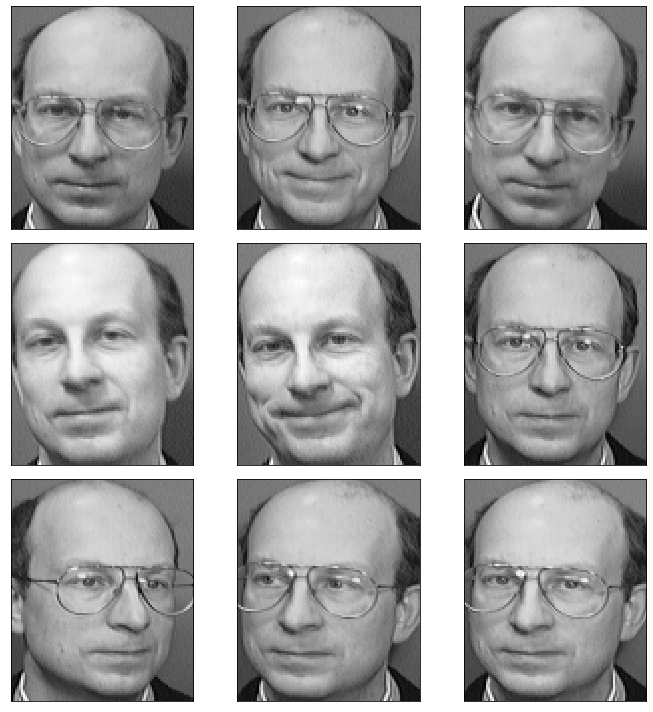

In [11]:
subject_idx = 4
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10))
subject_img_idx = np.where(y_train==subject_idx)[0].tolist()

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = x_train[subject_img_idx[i]]
    img = img.reshape(img.shape[0], img.shape[1])
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

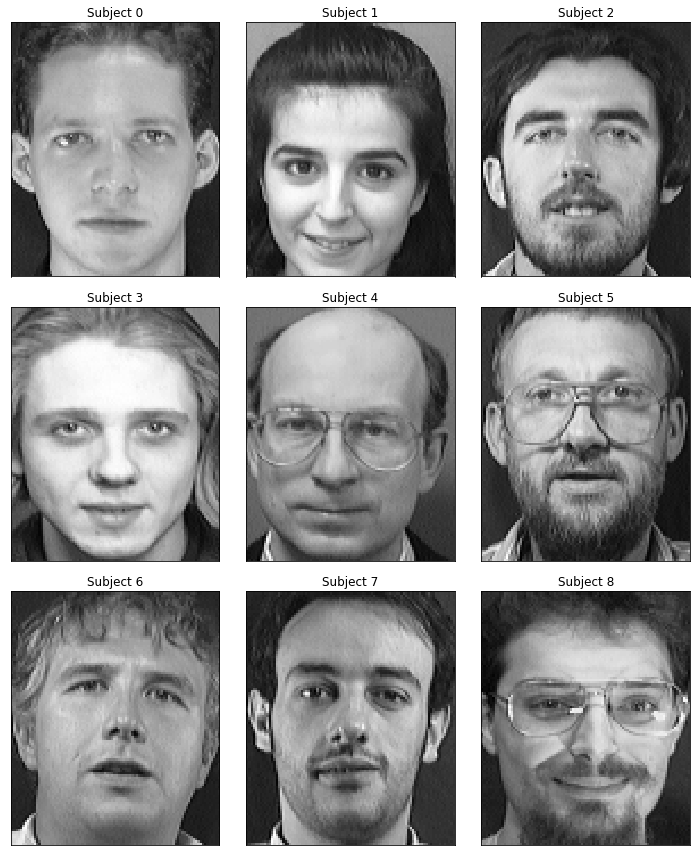

In [12]:
subjects = range(10)
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,
figsize=(10,12))
subject_img_idx = [np.where(y_train==i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = x_train[subject_img_idx[i]]
    img = img.reshape(img.shape[0], img.shape[1])
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Subject {}".format(i))

plt.tight_layout()
plt.show()

## Modeling

In [13]:
def create_shared_network(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model

In [14]:
input_shape = x_train.shape[1:]
shared_network = create_shared_network(input_shape)

In [15]:
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

In [16]:
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

In [17]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [18]:
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])

In [19]:
model = Model(inputs=[input_top, input_bottom], outputs=distance)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          18744768    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [21]:
# This function is copied from the book
def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  
    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1.0)
      
            # create negative pair
            # first, create list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0.0)
    return np.array(pairs), np.array(labels)

In [22]:
num_classes = len(np.unique(y_train))
training_pairs, training_labels = create_pairs(x_train, y_train, num_classes=num_classes)
test_pairs, test_labels = create_pairs(x_test, y_test, len(np.unique(y_test)))

In [23]:
def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean(Y_true * K.square(D) + (1 - Y_true) * K.maximum((margin-D),0))

In [24]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [25]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])

In [26]:
model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels, batch_size=64, epochs=10)

Epoch 1/10
10/10 [==============================] - 23s 2s/step - loss: 0.1956 - accuracy: 0.8389
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.1470 - accuracy: 0.8845
Epoch 3/10
10/10 [==============================] - 29s 3s/step - loss: 0.1112 - accuracy: 0.9226
Epoch 4/10
10/10 [==============================] - 33s 3s/step - loss: 0.0892 - accuracy: 0.9369
Epoch 5/10
10/10 [==============================] - 37s 4s/step - loss: 0.0805 - accuracy: 0.9385
Epoch 6/10
10/10 [==============================] - 32s 3s/step - loss: 0.0666 - accuracy: 0.9573
Epoch 7/10
10/10 [==============================] - 35s 4s/step - loss: 0.0834 - accuracy: 0.9182
Epoch 8/10
10/10 [==============================] - 32s 3s/step - loss: 0.0874 - accuracy: 0.9280
Epoch 9/10
10/10 [==============================] - 35s 4s/step - loss: 0.0616 - accuracy: 0.9604
Epoch 10/10
10/10 [==============================] - 32s 3s/step - loss: 0.0547 - accuracy: 0.9582


## Training Results

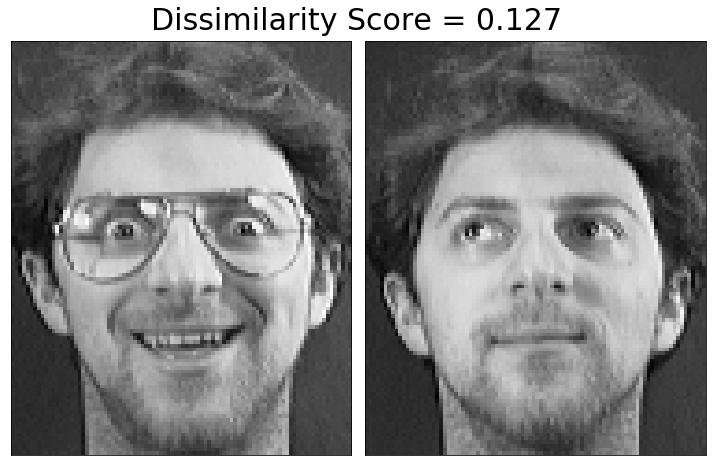

In [27]:
idx1, idx2 = 21, 29
img1 = np.expand_dims(x_test[idx1], axis=0)
img2 = np.expand_dims(x_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle('Dissimilarity Score = {:.3f}'.format(dissimilarity), size=30)
plt.tight_layout()
plt.show()

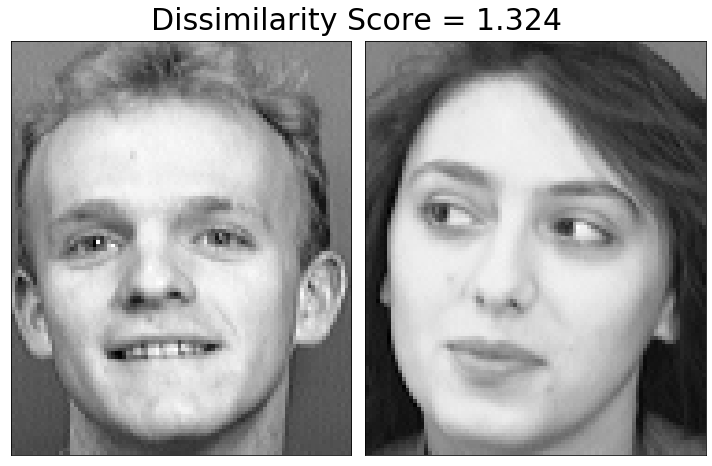

In [28]:
idx1, idx2 = 1, 39
img1 = np.expand_dims(x_test[idx1], axis=0)
img2 = np.expand_dims(x_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle('Dissimilarity Score = {:.3f}'.format(dissimilarity), size=30)
plt.tight_layout()
plt.show()

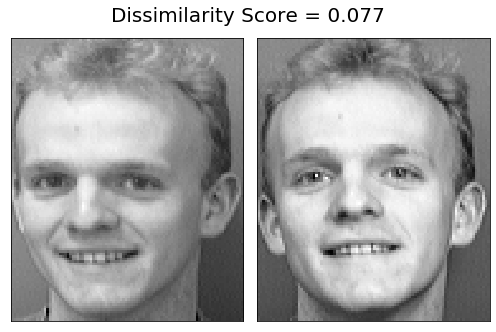

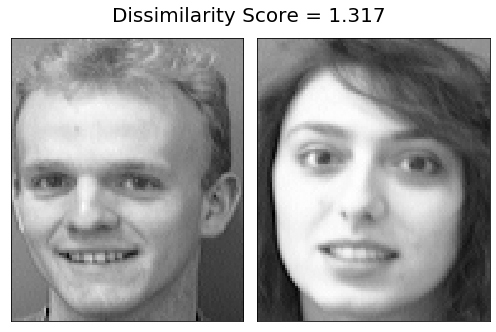

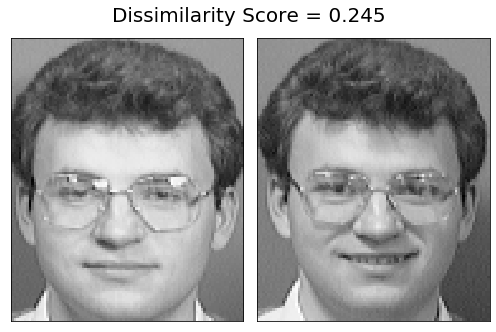

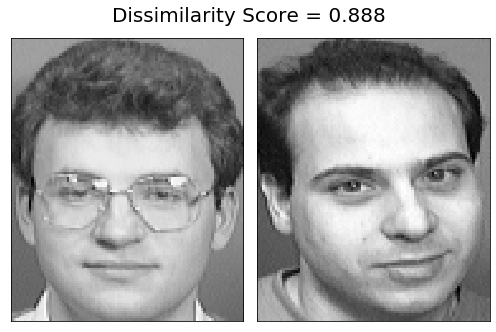

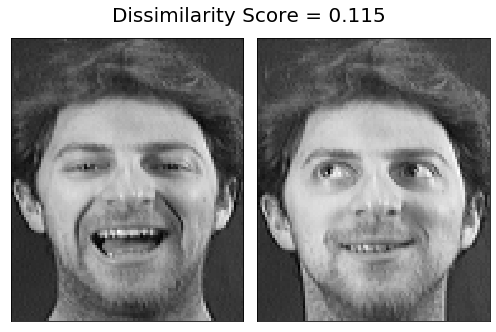

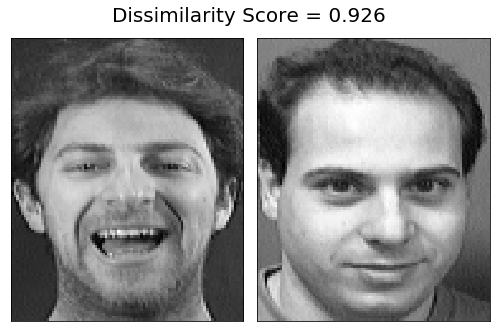

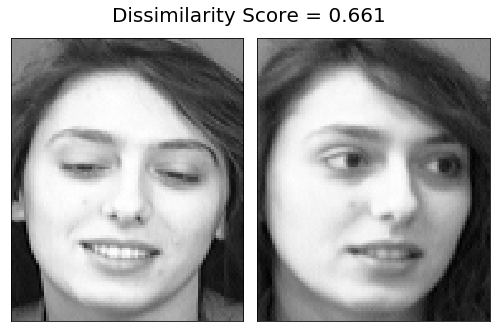

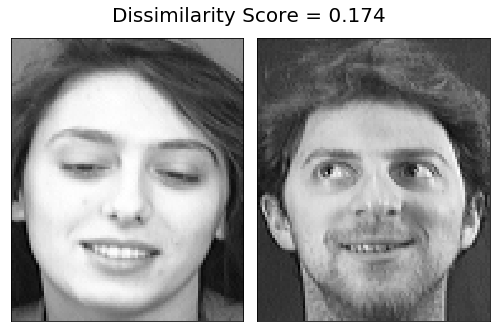

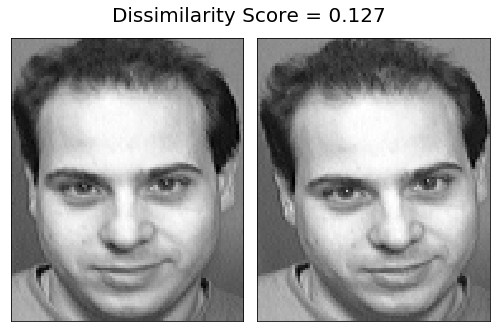

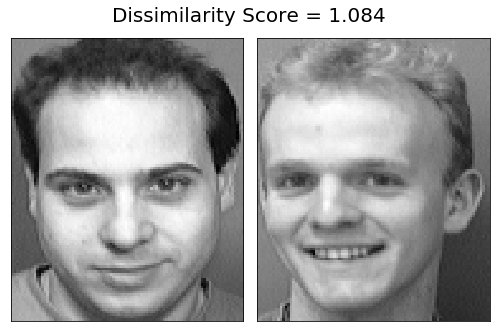

In [29]:
for i in range(5):
    for n in range(0, 2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
        img1 = np.expand_dims(test_pairs[i*20+n, 0], axis=0)
        img2 = np.expand_dims(test_pairs[i*20+n, 1], axis=0)
        dissimilarity = model.predict([img1, img2])[0][0]
        img1, img2 = np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.suptitle('Dissimilarity Score = {:.3f}'.format(dissimilarity), size=20)
plt.show()

In [31]:
model.save('siamese_nn.h5')
model.save_weights('siamese_nn_weights.h5')

## Facial Recognition - Onboarding

In [ ]:
video_capture = cv2.VideoCapture(0)
counter = 5

In [41]:
# These functions are from original code
def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame

In [ ]:
while True:
    _, frame = video_capture.read()
    frame, face_box, face_coords = detect_faces(frame)
    text = 'Image will be taken in {}..'.format(math.ceil(counter))
    if face_box is not None:
        frame = write_on_frame(frame, text, face_coords[0], face_coords[1]-10)
    cv2.waitKey(1)
    counter -= 0.1
    if counter <= 0:
        cv2.imwrite('true_img.png', face_box)
        break
video_capture.release()
cv2.destroyAllWindows()
print('Onboarding Image Captured')

### Recognition

In [32]:
name = input('What is your name?')

What is your name? Rebecca


In [34]:
def build_siamese_nn(x_train):
    input_shape = x_train.shape[1:]
    shared_network = create_shared_network(input_shape)
    
    input_top = Input(shape=input_shape)
    input_bottom = Input(shape=input_shape)
    
    output_top = shared_network(input_top)
    output_bottom = shared_network(input_bottom)
    
    distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])
    
    new_model = Model(inputs=[input_top, input_bottom], outputs=distance)
    new_model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
    
    return new_model

In [51]:
loaded_model = build_siamese_nn(x_train)
loaded_model.load_weights('siamese_nn_weights.h5')

In [50]:
true_img = cv2.imread('true_img.png', 0)
true_img = true_img.astype('float32') / 255
true_img = cv2.resize(true_img, (92, 112))
true_img = true_img.reshape(1, true_img.shape[0], true_img.shape[1], 1)

In [57]:
video_capture = cv2.VideoCapture(0)
preds = deque(maxlen=15)

while True:
    _, frame = video_capture.read()

    frame, face_img, face_coords = detect_faces(frame, draw_box=False)

    if face_img is not None:
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        face_img = face_img.astype('float32')/255
        face_img = cv2.resize(face_img, (92, 112))
        face_img = face_img.reshape(1, face_img.shape[0], face_img.shape[1], 1)
        preds.append(1-loaded_model.predict([true_img, face_img])[0][0])
        x,y,w,h = face_coords
        if len(preds) == 15 and sum(preds)/15 >= 0.3:
            print('face recognized!')
            text = "Identity: {}".format(name)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5)
            break
        elif len(preds) < 15:
            print('identifying face...')
            text = "Identifying ..."
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 165, 255), 5)
        else:
            print('Face could not be identified')
            text = "Identity Unknown!"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 5)
            break
        frame = write_on_frame(frame, text, face_coords[0], face_coords[1]-10)

    else:
        print('refreshing predictions')
        preds = collections.deque(maxlen=15)

    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
identifying face...
face recognized!
